In [1]:
path_to_data = "objs/p3d/"
file_name = 'mesh_0' # Assumes mtl and png have the same name

In [2]:
obj = {
    "v": [],
    "vt": [],
    "f": [],
    "ft": []
}
with open(f"{path_to_data}{file_name}.obj") as f:
    for i, line in enumerate(f):
        tokenized_line = line.split()
        key = tokenized_line[0]
        
        if key in ["mtllib", "usemtl"]:
            # could be important in the future             
            continue
        elif key == "f":
            numbers_pairs = [x.split("/") for x in tokenized_line[1:]]
            obj[key].append(list(map(lambda x: int(x[0]), numbers_pairs)))
            obj[f"{key}t"].append(list(map(lambda x: int(x[1]), numbers_pairs)))
        else:
            numbers = [float(x) for x in tokenized_line[1:]]
            obj[key].append(numbers)
        

In [3]:
import numpy as np

In [4]:
for key,value in obj.items():
    obj[key] = np.array(value)

In [5]:
import cv2
from matplotlib import pyplot as plt
import time

In [6]:
image = cv2.imread(f"{path_to_data}{file_name}.png")

In [7]:
image.shape

(512, 512, 3)

In [8]:
# mask = np.zeros(image.shape, dtype=np.uint8)
# for ft in obj["ft"]:
#     uv_coords = np.rint(obj["vt"][ft - 1] * image.shape[0]).astype(int)
# #     print(uv_coords)
# #     uv_coords = np.fliplr(uv_coords)
# #     print(uv_coords)
#     uv_coords = uv_coords.reshape((-1,1,2))
    
#     cv2.polylines(mask, [uv_coords], isClosed=True, color=(255,255,255), thickness=1)
#     cv2.fillPoly(mask, [uv_coords], (255,255,255))
#     masked_image = cv2.bitwise_and(image, mask)
#     plt.figure()
#     plt.imshow(masked_image)
#     plt.show()
#     time.sleep(5)
# #     1/0
    

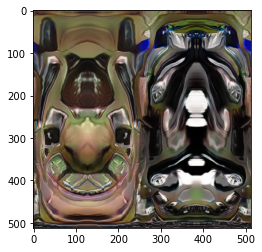

In [9]:
plt.imshow(image)

In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
# Relevant Code Here Taken From https://stackoverflow.com/questions/11851342/in-python-how-do-i-voxelize-a-3d-mesh
import voxelize.voxelize as voxelize

In [12]:
voxel = []
for f in obj["f"]:
    triangle = obj["v"][f - 1]
    new_voxel = voxelize.triangle_voxalize(triangle)
    for j in new_voxel:
        if j not in voxel:
            voxel.append(j)

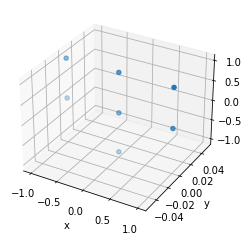

In [13]:
x_points = []
y_points = []
z_points = []
for a in range (len(voxel)):
    x_points.append(voxel[a][0])
    y_points.append(voxel[a][1])
    z_points.append(voxel[a][2])

## plot the voxel
ax = plt.axes(projection="3d")
ax.scatter3D(x_points, y_points, z_points)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## plot 1 layer of the voxel
for a in range (len(z_points)):
    if z_points[a] == 300:
        plt.scatter(x_points[a],y_points[a])

plt.show()

In [14]:
print(voxel)

[[0, 0, 0], [0, 0, -1], [0, 0, 1], [1, 0, 0], [1, 0, 1], [-1, 0, 1], [-1, 0, 0]]


In [15]:
resolution = 100

In [16]:
import torch
from kaolin.ops.conversions import trianglemeshes_to_voxelgrids, voxelgrids_to_cubic_meshes
import meshplot as mp

print(obj["v"].shape)
verts = torch.Tensor(obj["v"].copy()).unsqueeze(dim=0)
faces = torch.from_numpy(obj["f"].copy())

print(verts.shape)
print(faces.shape)
faces -= 1
print(faces.min())

voxel_grid = trianglemeshes_to_voxelgrids(verts.cuda(), faces.cuda(), resolution)
# c_v, c_f = voxelgrids_to_cubic_meshes(voxel_grid)
# mp.plot(c_v[0].cpu().numpy(), c_f[0].cpu().numpy())

voxel_grid = voxel_grid.cpu().numpy().squeeze()

(962, 3)
torch.Size([1, 962, 3])
torch.Size([1920, 3])
tensor(0)


In [17]:
min_val = torch.min(verts, dim=1)[0]
origin = min_val

max_val = torch.max(verts, dim=1)[0]
scale = torch.max(max_val - origin, dim=1)[0]

batch_size = verts.shape[0]
voxelgrids = torch.zeros((batch_size, resolution, resolution, resolution))

scaled = (verts - origin.unsqueeze(1)) / scale.view(-1, 1, 1)

print(scaled.max(), scaled.min())
print(min_val, max_val)

tensor(1.) tensor(0.)
tensor([[-0.5207, -0.4252, -1.0563]]) tensor([[0.5207, 0.3252, 0.9231]])


In [18]:
print(faces.numpy()[0])
triangle = (scaled * 49).squeeze().numpy()[faces.numpy()[10]]
vals = np.array(voxelize.triangle_voxalize(triangle))
print(vals)
print(voxel_grid[5, 13, 0])
print(vals.T.shape)
print(voxel_grid[vals[:, 0]].shape)
for x in vals:
    print(voxel_grid[x[0], x[1], x[2]])

[ 8 35  9]
[[13  6 49]
 [13  7 49]
 [14  7 49]]
0.0
(3, 3)
(3, 100, 100)
0.0
0.0
0.0


In [19]:
big = scaled * (resolution - 1)

voxel = []
# voxel_keys = np.arange(res ** 3).reshape((res, res, res))
voxel_to_faces = {}
for i, f in enumerate(faces.numpy()):
#     print(i)
#     print(f)
    triangle = (big).squeeze().numpy()[f]
#     print(triangle)
    vals = voxelize.triangle_voxalize(triangle)
    
    for j in vals:
#         voxel_key = voxel_keys[tuple(j)]
        voxel_key  = tuple(j)
        voxel_to_faces.setdefault(voxel_key, []).append(i)
        
        if j not in voxel: #if the point is new add it to the voxel
            voxel.append(j)
            
    

voxel = np.array(voxel)
    

In [20]:
print(voxel.shape)
cube_world = np.zeros((resolution,resolution,resolution))
cube_world[voxel[:,0],voxel[:,1], voxel[:,2]] = 1
cube_world_tensor = torch.from_numpy(cube_world)
cube_world_tensor = cube_world_tensor.unsqueeze(dim=0)

(17464, 3)


In [21]:
cube_world_tensor.shape

torch.Size([1, 100, 100, 100])

In [22]:
c_v, c_f = voxelgrids_to_cubic_meshes(cube_world_tensor)
mp.plot(c_v[0].cpu().numpy(), c_f[0].cpu().numpy())

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(26.5, 19.…

In [23]:
# Accuracy Of Transformation
# print(voxel_grid == cube_world)
(voxel_grid == cube_world).mean()

0.997658

In [24]:
# mask = np.zeros(image.shape, dtype=np.uint8)
# for ft in obj["ft"]:
#     uv_coords = np.rint(obj["vt"][ft - 1] * image.shape[0]).astype(int)
# #     print(uv_coords)
# #     uv_coords = np.fliplr(uv_coords)
# #     print(uv_coords)
#     uv_coords = uv_coords.reshape((-1,1,2))
    
#     cv2.polylines(mask, [uv_coords], isClosed=True, color=(255,255,255), thickness=1)
#     cv2.fillPoly(mask, [uv_coords], (255,255,255))
#     masked_image = cv2.bitwise_and(image, mask)
#     plt.figure()
#     plt.imshow(masked_image)
#     plt.show()
#     time.sleep(5)
# #     1/0
    

In [25]:
obj["f"].shape


(1920, 3)

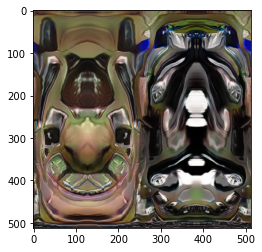

In [26]:
plt.imshow(image)

In [27]:
from sklearn.neighbors import NearestNeighbors
import os

In [28]:
block_path = "../MinecraftTextures/block/"
mean_colors = []
block_names = []
block_images = []
for file in os.listdir(block_path):
    if not file.endswith(".png"):
        continue
        
#     FILTER BY BLOCKS
#     if (not ('wool' in file or 'concrete.png' in file)):
#         continue
        
    block_image = cv2.imread(f"{block_path}{file}")
    mean_color = block_image.reshape((-1,3)).mean(axis=0)
    
    block_images.append(block_image)
    mean_colors.append(mean_color)
    block_names.append(file)
    
mean_colors = np.array(mean_colors)

In [29]:
# fit to blocks
neigh = NearestNeighbors(n_neighbors=1)
neigh.fit(mean_colors)

NearestNeighbors(n_neighbors=1)

In [30]:
metric = "weighted_euclidean"

# colored_voxels = np.zeros(cube_world.shape + (3,))
voxel_to_block = {}
for voxel_key, face_indexes in voxel_to_faces.items():
    mask = np.zeros(image.shape, dtype=np.uint8)
#     print(voxel_key)
    for f_idx in face_indexes:
#         f = obj["f"][f_idx] # Face
        ft = obj["ft"][f_idx]
        
        uv_coords = np.rint(obj["vt"][ft - 1] * image.shape[0]).astype(int)
        uv_coords = uv_coords.reshape((-1,1,2))

        cv2.polylines(mask, [uv_coords], isClosed=True, color=(255,255,255), thickness=1)
        cv2.fillPoly(mask, [uv_coords], (255,255,255))
    
    masked_array = np.ma.array(image, mask = mask == 255)
    masked_values = masked_array[masked_array.mask].data.reshape((-1,3))
    
    if metric == "avg":
        mean_color = masked_values.mean(axis=0)
        dists, block_ids = neigh.kneighbors([mean_color])
        b_id = block_ids[0][0]
    elif metric == "weighted_euclidean":
        mask_row, mask_col, _ = np.where(masked_array.mask)
        row_bounds = (mask_row.min(), mask_row.max()+1)
        col_bounds = (mask_col.min(), mask_col.max()+1)
#         print(row_bounds, col_bounds)
        sub_image = image[row_bounds[0]:row_bounds[1], col_bounds[0]:col_bounds[1], :]
        
        dists = []
        for img_idx, block_img in enumerate(block_images):
            resized_img = cv2.resize(block_img, (sub_image.shape[1], sub_image.shape[0]), interpolation = cv2.INTER_AREA)
            
            sqred_difference = (sub_image - resized_img)**2
#             Euclid
#             dist = np.sum(np.sqrt(sqred_difference))
    
#     Special
#             BGR color order weights from https://www.compuphase.com/cmetric.htm
            weights = np.array([3, 4, 2])
            weights = weights.reshape(1,1,3)
            dist = np.sum(np.sqrt(sqred_difference * weights))
            

            dists.append(dist)
        b_id = np.argmin(dists)
        
#         plt.figure()
#         plt.imshow(cv2.bitwise_and(image, mask))
#         plt.show()

#         plt.figure()
#         plt.imshow(cv2.cvtColor(sub_image, cv2.COLOR_BGR2RGB))
#         plt.show()
        
#         plt.figure()
#         plt.imshow(cv2.cvtColor(cv2.resize(block_images[b_id], (sub_image.shape[1], sub_image.shape[0]), interpolation = cv2.INTER_AREA), cv2.COLOR_BGR2RGB))
#         plt.show()
#         time.sleep(1)
#         print("---------------")
        
#         1/0
    block = block_names[b_id]
    voxel_to_block[voxel_key] = block
    

In [31]:
# voxel_to_block[(0,8,19)]

In [32]:
import pickle

In [33]:
with open(f"{path_to_data}/results/voxel_to_block_{file_name}", "wb") as f:
    pickle.dump(voxel_to_block, f)

with open(f'{path_to_data}/results/cube_world_{file_name}.npy', 'wb') as f:
    np.save(f, cube_world)

In [34]:
# voxel_to_block
